# Practice Activity 9.2
## Author: David Greco
### 11/22/24


Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, roc_auc_score, f1_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from plotnine import *
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None
     

In [16]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [29]:
X = ha.drop("cp", axis = 1)
y = ha["cp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
                                        make_column_selector(dtype_include=object))],
                                        remainder = "passthrough")

knn_pipeline = Pipeline(
    [("preprocessing", ct),
    ("classifier", KNeighborsClassifier(n_neighbors = 5))]
)

knn_fitted = knn_pipeline.fit(X_train, y_train)

knn_pred_train = knn_fitted.predict(X_train)
knn_pred_test = knn_fitted.predict(X_test)
knn_prob_test = knn_pipeline.predict_proba(X_test)

print("KNN Classification Report:\n", classification_report(y_test, knn_pred_test))
conf_matrix_knn = confusion_matrix(y_test, knn_pred_test)

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.91      0.62        22
           1       0.40      0.25      0.31         8
           2       0.43      0.15      0.22        20
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.32      0.33      0.29        55
weighted avg       0.40      0.45      0.37        55



c:\Users\elect\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\elect\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\elect\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.82      0.65        22
           1       0.36      0.50      0.42         8
           2       0.30      0.15      0.20        20
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.30      0.37      0.32        55
weighted avg       0.38      0.45      0.40        55



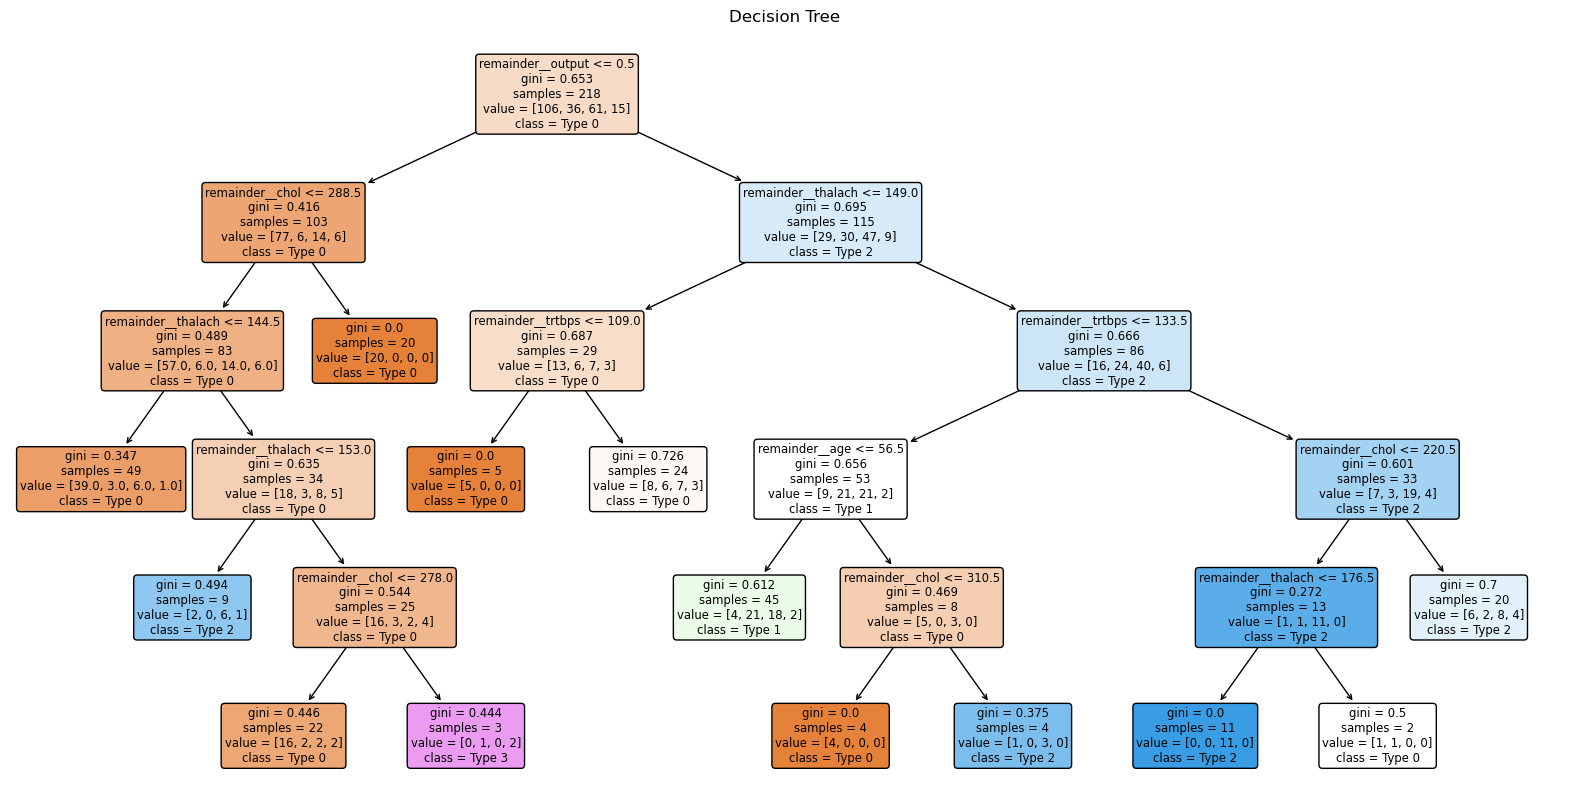

In [30]:
# Create a pipeline for the decision tree model that includes preprocessing and classification steps
tree1_pipeline = Pipeline([
    ("preprocessing", ct),  # Preprocessing step using the defined ColumnTransformer (ct)
    ("classifier", DecisionTreeClassifier(random_state=1, ccp_alpha=.01))  # Classifier step using DecisionTreeClassifier with specific parameters
])

# Fit the pipeline to the training data (X_train and y_train)
tree1_fitted = tree1_pipeline.fit(X_train, y_train)

# Access the fitted decision tree model from the pipeline
tree_model = tree1_fitted.named_steps["classifier"]

# Make predictions on the training data
tree1_pred_train = tree1_fitted.predict(X_train)

# Make predictions on the test data
tree1_pred_test = tree1_fitted.predict(X_test)

# Predict the probabilities for each class in the test data
tree1_prob_test = tree1_pipeline.predict_proba(X_test)

# Export the decision rules from the trained decision tree model in a text format
tree_rules = export_text(tree_model, feature_names=ct.get_feature_names_out())

# Print the classification report for the predictions on the test data
print("Decision Tree Classification Report:\n", classification_report(y_test, tree1_pred_test))

# Create a confusion matrix to evaluate the performance of the classifier on the test data
conf_matrix_tree = confusion_matrix(y_test, tree1_pred_test)

# Set up a figure for plotting the decision tree
plt.figure(figsize=(20, 10))

# Plot the decision tree using the trained model, feature names, and class names
plot_tree(
    tree_model,  # The decision tree model to plot
    feature_names=ct.get_feature_names_out(),  # Feature names for the tree
    class_names=["Type 0", "Type 1", "Type 2", "Type 3"],  # Class labels (update as needed)
    filled=True,  # Fill colors based on the class
    rounded=True  # Round the corners of the nodes
)

# Add a title to the plot
plt.title("Decision Tree")

# Display the plot
plt.show()


In [31]:
lda_pipeline = Pipeline(
    [("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis())]
)


lda_fitted = lda_pipeline.fit(X_train, y_train)
lda_model = lda_fitted.named_steps["lda"]
lda_pred_test = lda_pipeline.predict(X_test)

print("LDA Classification Report:\n", classification_report(y_test, lda_pred_test))
conf_matrix_lda = confusion_matrix(y_test, lda_pred_test)

LDA Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.71        22
           1       0.29      0.25      0.27         8
           2       0.45      0.50      0.48        20
           3       0.00      0.00      0.00         5

    accuracy                           0.53        55
   macro avg       0.35      0.38      0.36        55
weighted avg       0.47      0.53      0.50        55



c:\Users\elect\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\elect\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\elect\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [32]:
ha["cp_is_3"] = (ha['cp'] == 3).astype(int)
ha["cp_is_2"] = (ha['cp'] == 2).astype(int)
ha["cp_is_1"] = (ha['cp'] == 1).astype(int)
ha["cp_is_0"] = (ha['cp'] == 0).astype(int)

In [34]:
def logistic_regression_cv(X, target_column, columns_to_drop):
    y = X[target_column]
    X = X.drop(columns=columns_to_drop, axis=1)
    
    # Set up a ColumnTransformer to handle categorical variables and preprocessing
    ct = ColumnTransformer(
        [("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
          make_column_selector(dtype_include=object))],
        remainder="passthrough"
    )
# Create a pipeline that first preprocesses the data and then fits the Logistic Regression model
    log_pipeline = Pipeline([
        ("preprocessing", ct),
        ("log", LogisticRegression(max_iter=100))
    ])

    lr_scores = cross_val_score(log_pipeline, X, y, cv=5, scoring="f1_macro")

    mean_score = lr_scores.mean()
    print(f"Mean f1_macro score for {target_column}: {mean_score:.4f}")
    

cp_drop = ["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0", "cp"]
cp3_target = "cp_is_3"
cp2_target = "cp_is_2"
cp1_target = "cp_is_1"
cp0_target = "cp_is_0"
# Define the columns to drop and the target variables for classification
logistic_regression_cv(ha, cp3_target, cp_drop)
logistic_regression_cv(ha, cp2_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)
logistic_regression_cv(ha, cp1_target, cp_drop)

Mean f1_macro score for cp_is_3: 0.4800
Mean f1_macro score for cp_is_2: 0.4328
Mean f1_macro score for cp_is_1: 0.4540
Mean f1_macro score for cp_is_1: 0.4540


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [35]:
# Drop the individual chest pain type columns from the DataFrame
ha = ha.drop(["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis=1)

# Define a function to compare chest pain categories
def compare_cp(ha, comparison_value):
    # Filter the DataFrame to include rows where cp is either 0 or the comparison value
    ha_filtered = ha[(ha["cp"] == 0) | (ha["cp"] == comparison_value)]
    
    # Prepare the feature set by dropping the target variable
    X = ha_filtered.drop("cp", axis=1)
    # Set the target variable for classification
    y = ha_filtered["cp"]

    # Create a ColumnTransformer for preprocessing categorical features
    ct = ColumnTransformer([
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),  # One-hot encode categorical variables
        ],
        remainder="passthrough"  # Keep other columns unchanged
    )
    
    # Set up a pipeline that includes preprocessing and logistic regression
    log_pipeline = Pipeline([
        ("preprocessing", ct),  # Preprocessing step
        ("log", LogisticRegression(max_iter=100))  # Logistic regression model
    ])
    
    # Perform cross-validation with ROC AUC scoring
    lr_scores = cross_val_score(log_pipeline, X, y, cv=5, scoring="roc_auc")
    
    # Return the mean ROC AUC score
    return lr_scores.mean()

# Compare cp=0 with other cp categories and store the results
roc_auc_cp0_vs_1 = compare_cp(ha, 1)  # Compare cp=0 vs cp=1
roc_auc_cp0_vs_2 = compare_cp(ha, 2)  # Compare cp=0 vs cp=2
roc_auc_cp0_vs_3 = compare_cp(ha, 3)  # Compare cp=0 vs cp=3

# Print the ROC AUC scores for each comparison
print(f"ROC AUC (cp=0 vs cp=1): {roc_auc_cp0_vs_1:.4f}")
print(f"ROC AUC (cp=0 vs cp=2): {roc_auc_cp0_vs_2:.4f}")
print(f"ROC AUC (cp=0 vs cp=3): {roc_auc_cp0_vs_3:.4f}")


ROC AUC (cp=0 vs cp=1): 0.8010
ROC AUC (cp=0 vs cp=2): 0.7050
ROC AUC (cp=0 vs cp=3): 0.7391


**The OVO Pair that yielded the best results was between cp=0 and cp=1.**